In [ ]:
import pytorch_lightning as pl
import torch.cuda
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from wsi_dataset import WSIDataModule
import yaml
import importlib
from models import MILModel,compute_c_index
import os
import random
import numpy as np
import torchmetrics.functional as tf
from models import compute_c_index,calculate_auc  
import glob
import json
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold
from pytorch_lightning.tuner.tuning import Tuner
from pytorch_lightning.strategies import DeepSpeedStrategy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
from lightning.pytorch.accelerators import find_usable_cuda_devices     
from wsi_dataset import *
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningDataModule
from torch.utils.data.distributed import DistributedSampler
from copy import deepcopy
from torch.utils.data import Sampler
from sklearn.metrics import accuracy_score, roc_auc_score
from pprint import pprint

In [ ]:
def read_config(fname):
    with open(f"../3_mil_classifier/configs/{fname}.yaml", mode="r",encoding='utf-8') as file:
        yml = yaml.load(file, Loader=yaml.Loader)
        return yml


def get_obj_from_str(string, reload=False):     # string: "models.report_only.report_only"  
    module, cls = string.rsplit(".", 1)  
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

class CoxSurvLoss(nn.Module):

    def __init__(self, reduction='mean'):
        super(CoxSurvLoss, self).__init__()

    def forward(self, hazards, time, c):
        '''
        # hazards: risk value (log risk) from the model output
        # time: event occurrence or observation time
        # c: Whether the event occurred (1 means the event occurred, 0 means truncated)
        '''

        # This calculation credit to Travers Ching https://github.com/traversc/cox-nnet
        # Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data
        
        hazards = hazards.squeeze()

        current_batch_len = len(time)

        R_mat = torch.zeros(
            [current_batch_len, current_batch_len], 
            dtype=int, 
            device=hazards.device
            )

        for i in range(current_batch_len):
            for j in range(current_batch_len):
                R_mat[i,j] = time[j] >= time[i]
                
        theta = hazards.reshape(-1)
        exp_theta = torch.exp(theta)
        loss_cox = -torch.mean((theta - torch.log(torch.sum(exp_theta*R_mat, dim=1))) * c)

        return loss_cox
    
def calculate_auc(logits, labels):
    # Convert logits to probabilities using softmax
    probabilities = torch.softmax(logits, dim=1)
    # Convert probabilities and labels to CPU tensors
    probabilities = probabilities.cpu().detach().numpy()
    labels = labels.cpu().numpy()
    
    num_classes = probabilities.shape[1]
    
    if num_classes == 2:
        # Binary classification case
        unique_labels = np.unique(labels)
        # print(f'unique_labels: {unique_labels}')
        if len(unique_labels) == 2:
            # Binary classification with two classes (0 and 1)
            binary_probabilities = probabilities[:, 1]
            auc = roc_auc_score(labels, binary_probabilities)  
        else:
            # Binary classification with more than two classes
            print(f'*************There is only one real tag in the binary classification task, and the AUC cannot be calculated.**************')
            auc = 0
        
    else:
        # Multiclass case
        aucs = []
        unique_labels = np.unique(labels)
        if len(unique_labels) == 1 :
            print(f'*************There is only one real tag in a multi-class task, and the AUC cannot be calculated. tag in the multiclass classification task, and the AUC cannot be calculated.**************')
            auc = 0
            return auc
        else:
            for i in unique_labels: 
                i = int(i)
                binary_labels = (labels == i).astype(int)
                class_probabilities = probabilities[:, i]
                auc = roc_auc_score(binary_labels, class_probabilities)
                aucs.append(auc)
            auc = sum(aucs) / len(unique_labels)  
    
    return auc


def compute_P_value(hazard_scores: torch.Tensor, labels:torch.Tensor, status:torch.Tensor) -> np.ndarray:  
    from lifelines.statistics import logrank_test  

    all_hazard_scores = hazard_scores.cpu().numpy()
    all_hazard_ratios = np.exp(all_hazard_scores)
    all_labels = labels.cpu().numpy()
    all_status = status.cpu().numpy()
    assert len(all_hazard_scores) == len(all_labels) == len(all_status)

    # Divide high and low risk groups by median all_hazard_ratios
    median_risk = np.median(all_hazard_scores)
    high_risk_mask = all_hazard_scores > median_risk
    low_risk_mask = ~high_risk_mask  # Reverse, indicating low risk

    # Obtain HR in high and low risk groups
    high_risk_HR = all_hazard_scores[high_risk_mask]
    low_risk_HR = all_hazard_scores[low_risk_mask]

    # Get indexes for high-risk groups
    high_risk_indices = np.where(high_risk_mask)[0]
    low_risk_indices = np.where(low_risk_mask)[0]

    # Get the corresponding data by index
    high_risk_labels = all_labels[high_risk_indices]
    high_risk_status = all_status[high_risk_indices]

    low_risk_labels = all_labels[low_risk_indices]
    low_risk_status = all_status[low_risk_indices]


    # 4.Calculate p_value
    results = logrank_test(
        durations_A=high_risk_labels,
        durations_B=low_risk_labels,
        event_observed_A=high_risk_status,
        event_observed_B=low_risk_status,
    )
    p_value = results.p_value
    return p_value


# seed everything
def fix_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)   # Setting python hash seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.set_deterministic(True)  # torch < 1.8
    torch.use_deterministic_algorithms(True, warn_only=True)  # torch >= 1.8

In [ ]:
# Use bootstrap to calculate AUC and C-index 95% Confidence Interval
def bootstrap_auc(y_true: np.ndarray | torch.Tensor | list, 
                  y_prob: np.ndarray | torch.Tensor | list, 
                  n_bootstrap: int = 3000, 
                  alpha: float = 0.05) -> tuple[float, float, float, float]:
    """
    Compute the 95% CI, auc_mean and auc_std using the Bootstrap method.

    Parameters:
        y_true (array-like): True labels. Can be a numpy array, torch tensor, or list.
        y_prob (array-like): Predicted probabilities. [n_samples, n_classes] Can be a numpy array, torch tensor, or list.
        n_bootstrap (int, optional): Number of bootstrap resampling iterations. Default is 3000.
        alpha (float, optional): Significance level for confidence interval. Default is 0.05 (corresponding to 95% CI).

    Returns:
        tuple: A tuple containing:
            - auc_mean (float): Mean AUC for binary, Mean Macro-AUC for Multiclasses from bootstrap samples.
            - ci_lower (float): Lower bound of the 95% confidence interval.
            - ci_upper (float): Upper bound of the 95% confidence interval.
            - auc_std (float): Standard deviation of AUC values from bootstrap samples.
    """
    # Convert inputs to numpy arrays if they are not already
    def to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.cpu().numpy()  # Move tensor to CPU and convert to np.ndarray
        return np.array(x) if isinstance(x, list) else x

    y_true = to_numpy(y_true)
    if len(np.unique(y_true)) <= 1:
        raise ValueError("y_true contains only one unique class. At least two classes are required for AUC computation.")
    y_true_numbers = np.unique(y_true)
    y_prob = to_numpy(y_prob)
    n_classes = y_prob.shape[1]
    n_samples = len(y_true)

    auc_values = []
    if n_classes == 2:
        # Binary classification
        assert len(np.unique(y_true)) == 2, "y_true should contain only two unique classes for binary classification."
        for _ in range(n_bootstrap):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            if len(np.unique(y_true[indices])) == 2:
                auc = roc_auc_score(y_true[indices], y_prob[indices][:, 1])
                auc_values.append(auc)

    elif n_classes > 2:  # Multiclass classification
        if len(np.unique(y_true)) < n_classes:
            # Handle the case where len(np.unique(y_true)) < n_classes
            # Calculate AUC for each existing class and average them
            existing_classes = np.unique(y_true)
            for _ in range(n_bootstrap):
                indices = np.random.choice(n_samples, size=n_samples, replace=True)
                class_aucs = []
                for cls in existing_classes:
                    cls = int(cls)
                    binary_y_true = (y_true[indices] == cls).astype(int)  # Convert to binary classification for the current class
                    if len(np.unique(binary_y_true)) == 2:  # Ensure both classes are present
                        auc = roc_auc_score(binary_y_true, y_prob[indices][:, cls])
                        class_aucs.append(auc)
                if len(class_aucs) > 0:
                    auc_values.append(np.mean(class_aucs))

        elif len(np.unique(y_true)) == n_classes:
            # Handle the case where len(np.unique(y_true)) == n_classes. Use 'Macro-AUC' to calculate AUC for each class and average them
            for _ in range(n_bootstrap):
                indices = np.random.choice(n_samples, size=n_samples, replace=True)
                if len(np.unique(y_true[indices])) == n_classes:
                    auc = roc_auc_score(y_true[indices], y_prob[indices], average='macro', multi_class='ovr')
                    auc_values.append(auc)
    
    if len(auc_values) == 0:
        raise ValueError("Bootstrap did not generate valid samples. This may occur if the data contains only one class or is highly imbalanced.")
    
    auc_values = np.array(auc_values)
    
    # Calculate 95% CI and mean, standard deviation
    ci_lower = np.percentile(auc_values, 100 * alpha / 2)  # Lower bound of CI
    ci_upper = np.percentile(auc_values, 100 * (1 - alpha / 2))  # Upper bound of CI
    auc_mean = np.mean(auc_values)  # Mean AUC
    auc_std = np.std(auc_values)  # Standard deviation of AUC values
    
    return auc_mean, ci_lower, ci_upper, auc_std, auc_values


# Calculate C-index, Concordance Index
from sksurv.metrics import concordance_index_censored

def bootstrap_cindex(risks: np.ndarray | torch.Tensor | list,
                     pfs: np.ndarray | torch.Tensor | list, 
                     status: np.ndarray | torch.Tensor | list, 
                     n_bootstrap: int = 3000,
                     alpha: float = 0.05) -> tuple[float, float, float, float]:
    """
    Compute the 95% CI, Cindex_mean and Cindex_std using the Bootstrap method.

    Parameters:
        risks (array-like): Predicted risks. Can be a numpy array, torch tensor, or list.
        pfs (array-like): True survival times. Can be a numpy array, torch tensor, or list.
        status (array-like): Event indicators (1 if event occurred, 0 otherwise). Can be a numpy array, torch tensor, or list.
        n_bootstrap (int, optional): Number of bootstrap resampling iterations. Default is 3000.

    Returns:
        tuple: A tuple containing:
            - cindex_mean (float): Mean C-index from bootstrap samples.
            - ci_lower (float): Lower bound of the 95% confidence interval.
            - ci_upper (float): Upper bound of the 95% confidence interval.
            - cindex_std (float): Standard deviation of C-index values from bootstrap samples.
    """
    # Convert inputs to numpy arrays if they are not already
    def to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.cpu().numpy()  # Move tensor to CPU and convert to np.ndarray
        return np.array(x) if isinstance(x, list) else x

    risks = to_numpy(risks)
    pfs = to_numpy(pfs)
    status = to_numpy(status)

    cindex_values = []
    
    # Bootstrap resampling
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(risks), size=len(risks), replace=True)
        if len(np.unique(status[indices])) > 1:
            status = status.astype(bool)
            cindex = concordance_index_censored(status[indices], pfs[indices], np.squeeze(risks[indices]))[0]
            cindex_values.append(cindex)

    if len(cindex_values) == 0:
        raise ValueError("Bootstrap did not generate valid samples. This may occur if the data contains only one class or is highly imbalanced.")
    
    cindex_values = np.array(cindex_values)

    # Calculate 95% CI and mean, standard deviation
    ci_lower = np.percentile(cindex_values, 100 * alpha / 2)  # Lower bound of CI
    ci_upper = np.percentile(cindex_values, 100 * (1 - alpha / 2))  # Upper bound of CI
    cindex_mean = np.mean(cindex_values)  # Mean C-index
    cindex_std = np.std(cindex_values)  # Standard deviation of C-index values
    return cindex_mean, ci_lower, ci_upper, cindex_std, cindex_values


#### Internal Test set

In [ ]:
# ! Inetrnal Test Set,NEVA multi-modal
all_top_entries = []
MultiModal_list=['config_cls_hazard_level_MultiModal','config_cls_subtype_MultiModal',
                 'config_cls_shimada_MultiModal','config_cls_mki_MultiModal',
                 'config_cls_alk_MultiModal','config_cls_cmyc_MultiModal',
                 'config_cls_nmyc_MultiModal','config_cls_p36_MultiModal','config_cls_q23_MultiModal',
                 'config_reg_pfs_MultiModal','config_reg_os_MultiModal',]

for fname in MultiModal_list:
    config_yaml = read_config(fname)
    original_csv = f"./dataset_csv/Internal_test_set/{config_yaml['Data']['label_name']}.csv"
    proj_name = config_yaml['Data']['label_name']   
    if proj_name in ['pfs','os']:
        mode = 'mean'
        print(f'\n{proj_name},mode:{mode}')
    else:
        mode = 'best'
        if proj_name == 'hazard_level':
            print(f'\nRisk Group,mode:{mode}')
        else:
            print(f'\n{proj_name},mode:{mode}')


    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    num_gpus = 1
    dist = False 
    seed,fold = config_yaml['seed&fold']

    wts_dir = f"./model_weights/{fname}/{proj_name}/seed{seed}"
    csv_path = f"{wts_dir}/five_fold.csv"   
    all_data_csv_path = f"./dataset_csv/Internal_test_set/{proj_name}.csv"
    print(f"csv_path: {csv_path}")

    assert os.path.exists(csv_path), f"CSV file not found: {csv_path}"
    assert os.path.exists(all_data_csv_path), f"CSV file not found: {all_data_csv_path}"
    df_all_data = pd.read_csv(all_data_csv_path)
    df = pd.read_csv(csv_path)

    metric = []

    test_df = df[df['fold'] == fold].copy()
    test_df_case_ids = test_df['case_id'].tolist()
    train_df = df[df['fold'] != fold].copy()
    train_df_case_ids = train_df['case_id'].tolist()
    os.makedirs(f"./outputs/Internal_test_set/{proj_name}/", exist_ok=True)

    if proj_name not in ['pfs','os']:
        if test_df[str(proj_name)].nunique() == 1:
            print(f'{proj_name}There is only one category, cannot calculate auc/cindex')
            continue
        
    patient_files = {}
    for index, row_test in test_df.iterrows():
        case_id = row_test['case_id']  
        if case_id not in patient_files:
            patient_files[case_id] = []
        patient_files[case_id].append(row_test['filename'])


    feature_dict = {}
    for file_name in test_df['filename']:
        file_path = '../2_extract_features/outputs/images/' + file_name
        feature_dict[file_name[:-len('.pt')]] = file_path

    patient_files = {str(k): [feature_dict[i[:-len('.pt')]] for i in v] for k, v in patient_files.items()}
    patient_feature_vision = {case_id: [torch.load(file_name,map_location=device).unsqueeze(0).float() for file_name in file_list] for case_id, file_list in patient_files.items()}

    test_df.drop_duplicates(subset=['case_id'], inplace=True)  
    test_df.reset_index(drop=True, inplace=True) 
    test_df['case_id'] = test_df['case_id'].astype(str)  
    if config_yaml['Data']['label_name'] in ['os','pfs']:
        all_labels = torch.tensor(test_df['time'].values)
        all_status = torch.tensor(test_df['status'].values)
        all_case_id_label = {case_id : (torch.tensor(test_df[test_df['case_id']==case_id]['time'].tolist()),torch.tensor(test_df[test_df['case_id']==case_id]['status'].tolist())) for case_id,feature_list in patient_feature_vision.items()}
    else:
        all_labels = torch.tensor(test_df[config_yaml['Data']['label_name']].values)  
        all_case_id_label = {case_id : torch.tensor(test_df[test_df['case_id']==case_id][config_yaml['Data']['label_name']].tolist()) for case_id,feature_list in patient_feature_vision.items()}
    
    patient_feature_report = {str(case_id):torch.load('../2_extract_features/outputs/report_large/'+str(case_id)+'.pt',map_location=device).unsqueeze(dim=0).float() for case_id in test_df['case_id']}
    assert len(patient_feature_vision.keys())==len(patient_feature_report.keys())

    with torch.inference_mode():
        wts_path = f"./model_weights/{proj_name}.pth"
        wts = torch.load(wts_path)
        save_path = None
        model = MILModel(config_yaml, save_path=str(save_path)).to(device)
        model.load_state_dict(wts,strict=True)
        criterion = get_obj_from_str(config_yaml["Loss"]["name"])(**config_yaml["Loss"]["params"])
        case_id_logits={}

        for case_id,feature_list_vision in patient_feature_vision.items():  

            if case_id not in patient_feature_report:
                print(f"{case_id} Not in the patient's pathological report")
                print(patient_feature_report)
            feature_report = patient_feature_report[case_id].to(device)
            logits = []
            for feature_vision in feature_list_vision:
                feature_vision = feature_vision.to(device)
                with torch.inference_mode():  
                    logit, results_dict = model((feature_vision,feature_report))

                logits.append(logit)

            if mode == 'mean':
                case_id_logits[case_id]=torch.cat(logits,dim=0).mean(dim=0,keepdim=True) 

            if mode == 'best':
                case_id_logits[case_id] = logits[0]
                best_logit = logits[0]
                if config_yaml['Data']['label_name'] in ['os','pfs']:
                    label,status = all_case_id_label[case_id]
                    label = label.long().to(device)
                    status = status.long().to(device)
                    criterion = CoxSurvLoss()
                    best_crossentropy = criterion(logits[0].float(),label,status)
                    for logit in logits[1:]:
                        crossentropy = criterion(logit,label,status)
                        if crossentropy <= best_crossentropy:
                            case_id_logits[case_id] = logit
                else:
                    label = all_case_id_label[case_id].long().to(device)

                    criterion = nn.CrossEntropyLoss()
                    best_crossentropy = criterion(logits[0].float(),label)
                    for logit in logits[1:]:
                        crossentropy = criterion(logit,label)
                        if crossentropy <= best_crossentropy:
                            case_id_logits[case_id] = logit

        del patient_feature_vision, patient_feature_report
        all_logits = torch.cat([logits for case_id,logits in case_id_logits.items()],dim = 0)

        if config_yaml['Data']['label_name'] in ['os','pfs']:

            risks_list = all_logits
            labels_list = all_labels
            status_list = all_status
            c_index =float(round(compute_c_index(risks_list, labels_list, status_list), 4))
            p_value = float(round(compute_P_value(risks_list, labels_list, status_list), 4))
            print(f'c_index:{c_index},p_value:{p_value}')
            
            bootstrap_cindex_mean, ci_lower, ci_upper, cindex_std, cindex_values = bootstrap_cindex(risks_list, labels_list, status_list)
            print(f'bootstrap_cindex_mean & CI:\n{bootstrap_cindex_mean:.4f} ({ci_lower:.4f}--{ci_upper:.4f}), {p_value}\n')
            metric.append(bootstrap_cindex_mean)

        else:
            all_probs = torch.softmax(all_logits, dim=1)
            print(f"all_labels: {all_labels.shape}, all_probs: {all_probs.shape}")
            bootstrap_auc_mean, ci_lower, ci_upper, auc_std, auc_values = bootstrap_auc(all_labels, all_probs)
            print(f'bootstrap_auc_mean & CI:\n{bootstrap_auc_mean:.4f} ({ci_lower:.4f}--{ci_upper:.4f})\n')
            metric.append(bootstrap_auc_mean)
        del model
        del all_logits
        del all_labels
        torch.cuda.empty_cache()



Risk Group,mode:best
csv_path: /home/huruizhen/mil/workspace/2048维度/多模态/动态权重/模型/config_cls_hazard_level_MultiModal/hazard_level/seed493/five_fold.csv
all_labels: torch.Size([93]), all_probs: torch.Size([93, 3])
bootstrap_auc_mean & CI:
0.7858 (0.7017--0.8647)


subtype,mode:best
csv_path: /home/huruizhen/mil/workspace/2048维度/多模态/动态权重/模型/config_cls_subtype_MultiModal/subtype/seed648/five_fold.csv
all_labels: torch.Size([170]), all_probs: torch.Size([170, 3])
bootstrap_auc_mean & CI:
0.9698 (0.9499--0.9865)


shimada,mode:best
csv_path: /home/huruizhen/mil/workspace/2048维度/多模态/动态权重/模型/config_cls_shimada_MultiModal/shimada/seed739/five_fold.csv
all_labels: torch.Size([181]), all_probs: torch.Size([181, 2])
bootstrap_auc_mean & CI:
0.8357 (0.7720--0.8939)


mki,mode:best
csv_path: /home/huruizhen/mil/workspace/2048维度/多模态/动态权重/模型/config_cls_mki_MultiModal/mki/seed526/five_fold.csv
all_labels: torch.Size([127]), all_probs: torch.Size([127, 3])
bootstrap_auc_mean & CI:
0.8235 (0.7634--0.8775

### Prospective test set, external PUFH, SCH, and GCI test sets

In [ ]:
# Prospective test set, external PUFH, SCH, and GCI test sets

all_top_entries = []

csv_dir_list = ['./dataset_csv/Prospective','./dataset_csv/PUFH',
                './dataset_csv/SCH',
                './dataset_csv/GCI',]

for csv_dir in csv_dir_list:  
    hospital_center = os.path.basename(csv_dir)
    print(f'\n\n***************Cohorts：{hospital_center}***************')
    proj_name_list = [proj_name.replace('.csv','') for proj_name in os.listdir(csv_dir) if proj_name.endswith('.csv')]
    MultiModal_list = []
    for proj_name in proj_name_list:
        if proj_name in ['pfs','os']:
            MultiModal_list.append('config_reg_'+proj_name+'_MultiModal')
        else:
            MultiModal_list.append('config_cls_'+proj_name+'_MultiModal')
    print(MultiModal_list)

    for fname in MultiModal_list:

        config_yaml = read_config(fname) 
        proj_name = config_yaml['Data']['label_name']

        seed,fold = config_yaml['seed&fold']

        if proj_name in ['pfs','os']:
            mode = 'mean'
            print(f'{proj_name}')
        else:
            mode = 'best'
            if proj_name == 'hazard_level':
                print(f'Risk Group')
            elif proj_name == 'p36':
                print(f'1p36')
            elif proj_name == 'q23':
                print(f'11q23')
            else:
                print(f'{proj_name}')



        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # device = torch.device("cpu")
        num_gpus = 1
        dist = False 
        original_csv = os.path.join(csv_dir,config_yaml['Data']['label_name']+'.csv')   
        print(original_csv)


        test_df = pd.read_csv(original_csv) 
        test_df['case_id'] = test_df['case_id'].astype(str) 
        

        if test_df[str(proj_name)].nunique() == 1:
            print(f"{proj_name} There is only one category, cannot calculate auc/cindex")
            continue

        patient_files = {}
        for index, row in test_df.iterrows():
            case_id = row['case_id'] 
            if case_id not in patient_files:
                patient_files[case_id] = []
            patient_files[case_id].append(row['filename']) 

        feature_dict = {}
        for file_name in test_df['filename']:
            file_path = '../2_extract_features/outputs/images/'+file_name
            feature_dict[file_name[:-len('.pt')]]=file_path

        patient_files = {str(k): [feature_dict[i[:-len('.pt')]] for i in v] for k, v in patient_files.items()} 


        patient_feature_vision = {case_id: [torch.load(file_name,map_location=device).unsqueeze(0).float() for file_name in file_list] for case_id, file_list in patient_files.items()}   

        test_df.drop_duplicates(subset=['case_id'], inplace=True)  
        test_df.reset_index(drop=True, inplace=True)  
        test_df['case_id'] = test_df['case_id'].astype(str)  

        
        if config_yaml['Data']['label_name'] in ['os','pfs']:
            all_labels = torch.tensor(test_df[config_yaml['Data']['label_name']].values)
            all_status = torch.tensor(test_df['status'].values)
            all_case_id_label = {case_id : (torch.tensor(test_df[test_df['case_id']==case_id][config_yaml['Data']['label_name']].tolist()),torch.tensor(test_df[test_df['case_id']==case_id]['status'].tolist())) for case_id,feature_list in patient_feature_vision.items()}
        else:
            all_labels = torch.tensor(test_df[config_yaml['Data']['label_name']].values) 
            all_case_id_label = {case_id : torch.tensor(test_df[test_df['case_id']==case_id][config_yaml['Data']['label_name']].tolist()) for case_id,feature_list in patient_feature_vision.items()}

        patient_feature_report = {str(case_id):torch.load('../2_extract_features/outputs/report_large/'+str(case_id)+'.pt',map_location=device).unsqueeze(dim=0).float() for case_id in test_df['case_id']}

        assert len(patient_feature_vision.keys())==len(patient_feature_report.keys())


        save_path = f"./outputs/{hospital_center}/{proj_name}/"
        with torch.inference_mode():
            model = MILModel(config_yaml, save_path=str(save_path)).to(device)  

            criterion = get_obj_from_str(config_yaml["Loss"]["name"])(**config_yaml["Loss"]["params"])

            case_id_logits={}
            metric = []

            wts_path = f"./model_weights/{proj_name}.pth"
            wts = torch.load(wts_path)
            model.load_state_dict(wts,strict=True)

            for case_id,feature_list_vision in patient_feature_vision.items():
                case_id = str(case_id)
                if case_id not in patient_feature_report:
                    print(f"{case_id}Not in the patient's pathological report")
                    print(patient_feature_report)
                feature_report = patient_feature_report[case_id].to(device)
                logits = []
                for feature_vision in feature_list_vision:
                    feature_vision = feature_vision.to(device)

                    with torch.inference_mode():  
                        logit, results_dict = model((feature_vision,feature_report))

                    logits.append(logit)


                if mode == 'mean':
                    case_id_logits[case_id]=torch.cat(logits,dim=0).mean(dim=0,keepdim=True)  
                if mode == 'best':
                    case_id_logits[case_id] = logits[0]
                    best_logit = logits[0]
                    if config_yaml['Data']['label_name'] in ['os','pfs']:
                        label,status = all_case_id_label[case_id]
                        label = label.long().to(device)
                        status = status.long().to(device)
                        criterion = CoxSurvLoss()
                        best_crossentropy = criterion(logits[0].float(),label,status)
                        for logit in logits[1:]:
                            crossentropy = criterion(logit,label,status)
                            if crossentropy <= best_crossentropy:
                                case_id_logits[case_id] = logit
                    else:
                        label = all_case_id_label[case_id].long().to(device)

                        criterion = nn.CrossEntropyLoss()
                        best_crossentropy = criterion(logits[0].float(),label)
                        for logit in logits[1:]:
                            crossentropy = criterion(logit,label)
                            if crossentropy <= best_crossentropy:
                                case_id_logits[case_id] = logit
                
            all_logits = torch.cat([logits for case_id,logits in case_id_logits.items()],dim = 0)
            
            if config_yaml['Data']['label_name'] in ['os','pfs']:
                risks_list = all_logits
                labels_list = all_labels
                status_list = all_status
                c_index =float(round(compute_c_index(risks_list, labels_list, status_list),4))
                p_value = float(round(compute_P_value(risks_list, labels_list, status_list),4))
                print(f'c_index:{c_index},p_value:{p_value}')
                bootstrap_cindex_mean, ci_lower, ci_upper, cindex_std, cindex_values = bootstrap_cindex(risks_list, labels_list, status_list)
                print(f'bootstrap_cindex_mean & CI:\n{bootstrap_cindex_mean:.4f} ({ci_lower:.4f}--{ci_upper:.4f}), {p_value}\n')
                metric.append(bootstrap_cindex_mean)

            else:
                auc = float(round(calculate_auc(all_logits, all_labels), 4))
                all_probs = torch.softmax(all_logits, dim=1)
                print(f"all_labels: {all_labels.shape}, all_probs: {all_probs.shape}")
                bootstrap_auc_mean, ci_lower, ci_upper, auc_std, auc_values = bootstrap_auc(all_labels, all_probs)
                print(f'bootstrap_auc_mean & CI:\n{bootstrap_auc_mean:.4f} ({ci_lower:.4f}--{ci_upper:.4f})\n')
                metric.append(bootstrap_auc_mean)



***************Cohorts：Prospective***************
['config_cls_cmyc_MultiModal', 'config_cls_subtype_MultiModal', 'config_cls_hazard_level_MultiModal', 'config_cls_p36_MultiModal', 'config_cls_shimada_MultiModal', 'config_cls_nmyc_MultiModal', 'config_cls_mki_MultiModal', 'config_cls_alk_MultiModal', 'config_cls_q23_MultiModal']
cmyc
/home/huruizhen/mil/workspace/独立测试集/多中心测试/前瞻实验/cmyc.csv
all_labels: torch.Size([59]), all_probs: torch.Size([59, 2])
bootstrap_auc_mean & CI:
0.8756 (0.7673--0.9578)

subtype
/home/huruizhen/mil/workspace/独立测试集/多中心测试/前瞻实验/subtype.csv
all_labels: torch.Size([67]), all_probs: torch.Size([67, 3])
bootstrap_auc_mean & CI:
0.9484 (0.9048--0.9835)

Risk Group
/home/huruizhen/mil/workspace/独立测试集/多中心测试/前瞻实验/hazard_level.csv
all_labels: torch.Size([23]), all_probs: torch.Size([23, 3])
bootstrap_auc_mean & CI:
0.8814 (0.7263--0.9898)

1p36
/home/huruizhen/mil/workspace/独立测试集/多中心测试/前瞻实验/p36.csv
all_labels: torch.Size([33]), all_probs: torch.Size([33, 2])
bootstrap_

### Kaplan–Meier Curves for PFS and OS on the Internal and PUFH Test Sets: NMYC(true), NMYC(predicted), NEVA

/tmp/ipykernel_1405640/3697349813.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data[file[:-3]] = torch.load(file_path, map_location="cpu")
/home/huruizhen/min


Loaded data structure:

Internal_test_set:
  PFS:
    NEVA: ['logits', 'labels', 'status']
    NMYC(predicted): ['logits', 'labels', 'status']
    NMYC(true): ['logits', 'labels', 'status']
  OS:
    NEVA: ['logits', 'labels', 'status']
    NMYC(predicted): ['logits', 'labels', 'status']
    NMYC(true): ['logits', 'labels', 'status']

PUFH:
  PFS:
    NEVA: ['logits', 'labels', 'status']
    NMYC(predicted): ['logits', 'labels', 'status']
    NMYC(true): ['logits', 'labels', 'status']
  OS:
    NEVA: ['logits', 'labels', 'status']
    NMYC(predicted): ['logits', 'labels', 'status']
    NMYC(true): ['logits', 'labels', 'status']
NEVA
NEVA Internal_test_set PFS
(138, 1) (138,) (138,)
Median Hazard Score: -3.5102057456970215
High Risk mOS: inf months
Low Risk mOS: inf months
No median survival time available.
HR: 9.41 95% CI,(2.76, 32.06)
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logran

/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.507. This may imply non-unique solutions to the maximum likelihood. Perhaps there i

HR: 86354699.53 95% CI,(0.00, inf)
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.03 0.01      6.96
Log-Rank Test p-value: 0.008014337477196353

Statistical Information:
  Risk Group        No.    
---------------  ----------
   High Risk         17    
   Low Risk          18    

No. at Risk Table:
  No. at risk       0         10        20        30        40        50        60        70        80        90       100       110       120       130       140       150   
   Low Risk         18        15        14        14        14        14        14        13        13        11        9         2         2         0         0         0    
   High Risk        17        15        15        12        11        11        11        9         8         5         5         2         1         1         0         0    
Plot_OS_an

Permutation: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


Median Hazard Score: 0.9843608514829114
High Risk mOS: 90.5 months
Low Risk mOS: inf months
No median survival time available.
HR: 4.62 95% CI,(1.37, 15.60)
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.28 0.01      7.16
Log-Rank Test p-value: 0.00699094781221175

Statistical Information:
  Risk Group        No.    
---------------  ----------
   High Risk         7     
   Low Risk          57    

No. at Risk Table:
  No. at risk       0         10        20        30        40        50        60        70        80        90       100       110       120       130       140       150   
   Low Risk         57        54        48        43        36        34        20        9         8         4         1         0         0         0         0         0    
   High Risk        7         5         4         3         3    

Permutation: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]
/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.374. This may imply non-

Median Hazard Score: 0.9923168225721879
High Risk mOS: inf months
Low Risk mOS: inf months
No median survival time available.
HR: 87620094.27 95% CI,(0.00, inf)
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.16 <0.005      8.66
Log-Rank Test p-value: 0.002467382361818883

Statistical Information:
  Risk Group        No.    
---------------  ----------
   High Risk         7     
   Low Risk          36    

No. at Risk Table:
  No. at risk       0         10        20        30        40        50        60        70        80        90       100       110       120       130       140       150   
   Low Risk         36        36        30        29        27        25        17        12        9         1         1         1         0         0         0         0    
   High Risk        7         7         7         6     

Permutation: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]
/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.475. This may imply non-

Median Hazard Score: 0.6979031960169477
High Risk mOS: inf months
Low Risk mOS: inf months
No median survival time available.
HR: 62994393.11 95% CI,(0.00, inf)
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.90 <0.005      9.24
Log-Rank Test p-value: 0.001654111734789767

Statistical Information:
  Risk Group        No.    
---------------  ----------
   High Risk         11    
   Low Risk          23    

No. at Risk Table:
  No. at risk       0         10        20        30        40        50        60        70        80        90       100       110       120       130       140       150   
   Low Risk         23        19        18        18        18        18        18        15        15        11        9         1         1         0         0         0    
   High Risk        11        11        10        7     

Permutation: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]
/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.475. This may imply non-

Median Hazard Score: 0.6733978052934014
High Risk mOS: inf months
Low Risk mOS: inf months
No median survival time available.
HR: 61942153.59 95% CI,(0.00, inf)
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.79 <0.005      9.16
Log-Rank Test p-value: 0.0017498704917785178

Statistical Information:
  Risk Group        No.    
---------------  ----------
   High Risk         11    
   Low Risk          23    

No. at Risk Table:
  No. at risk       0         10        20        30        40        50        60        70        80        90       100       110       120       130       140       150   
   Low Risk         23        19        18        18        18        18        18        15        15        11        9         1         1         0         0         0    
   High Risk        11        11        11        8    

/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column group have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'group'].var())
>>> print(df.loc[~events, 'group'].var())

A very low variance means that the column group completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/huruizhen/miniconda3/envs/mil/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.359. This may imply non-unique solutions to the maximum likelihood. Perhaps there i

ROC curves saved to './output/svg'


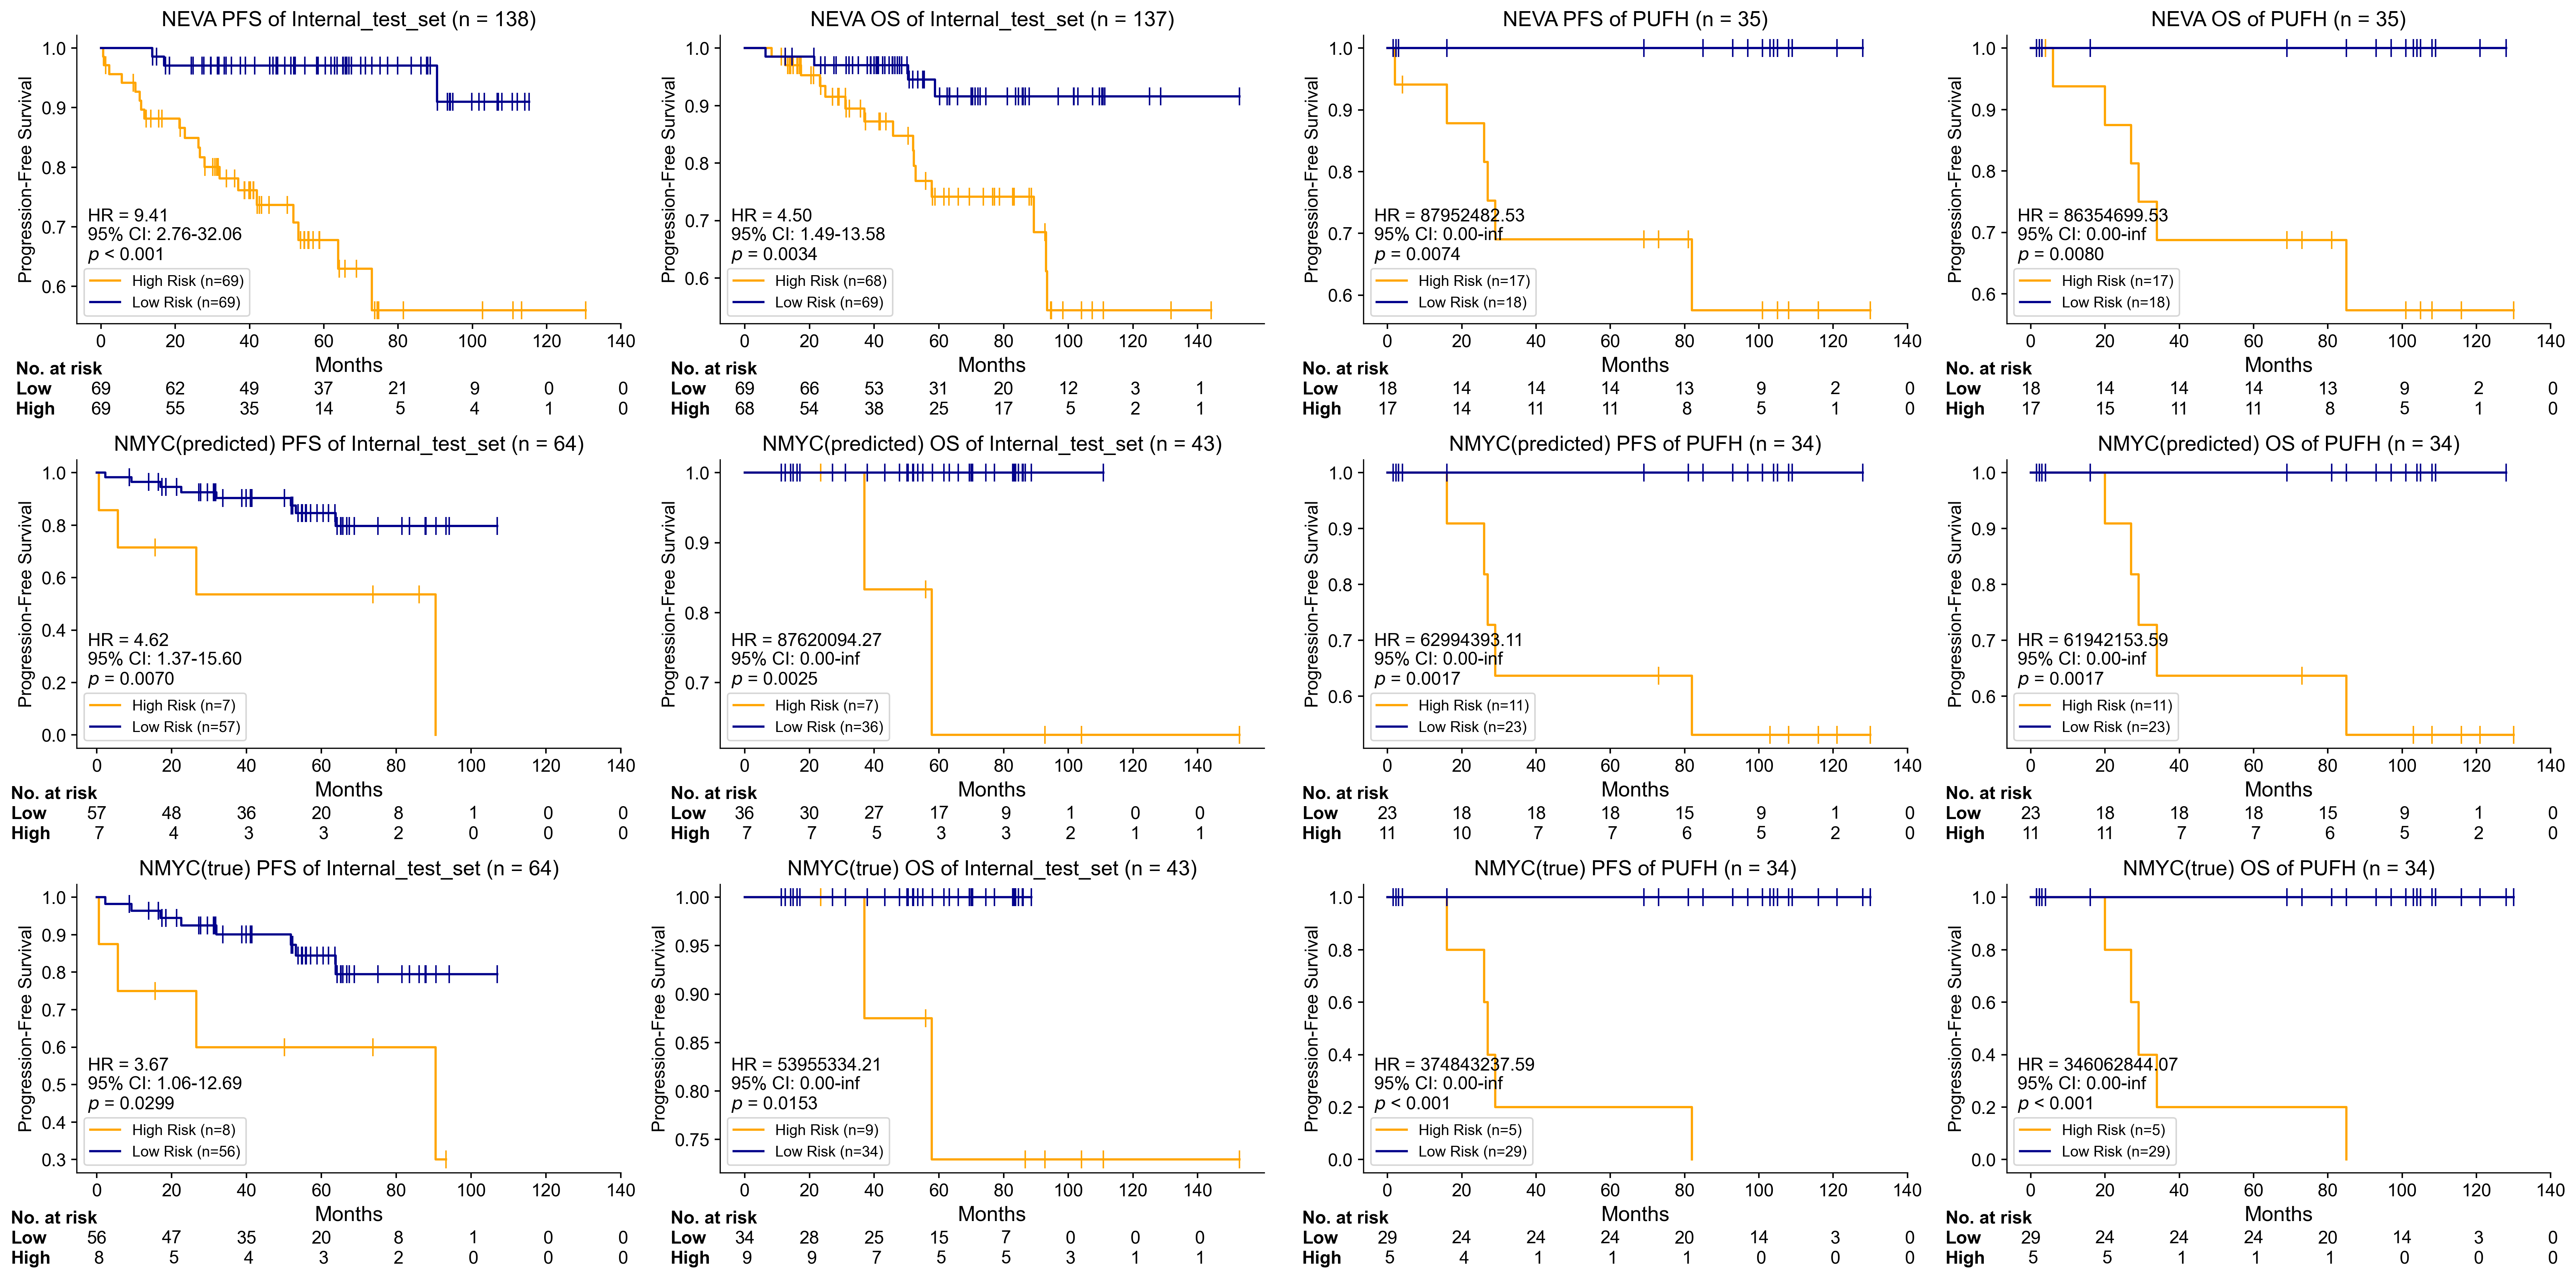

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from lifelines import KaplanMeierFitter,CoxPHFitter  
from lifelines.statistics import logrank_test        
from IPython.display import display
from dataclasses import dataclass
from typing import List
from tqdm import tqdm
import torch
import os
from typing import Dict, List
from dataclasses import dataclass, field
os.environ['KMP_DUPLICATE_LIB_OK']='True'
def maxstat_python(data, time_col, event_col, marker_col,
                   min_prop=0.1, max_prop=0.9, n_permutations=1000, seed=42, plot=True):
    """
    MaxStat + permutation-based p-value adjustment (pure Python version)

    Parameters
    ----------
    data : pd.DataFrame
        Input dataframe containing survival data and a continuous marker.
    time_col : str
        Column name for survival time.
    event_col : str
        Column name for event indicator (1=event, 0=censored).
    marker_col : str
        Column name for continuous marker variable.
    min_prop : float
        Lower quantile bound for candidate cutoffs.
    max_prop : float
        Upper quantile bound for candidate cutoffs.
    n_permutations : int
        Number of permutations for p-value adjustment.
    seed : int
        Random seed for reproducibility.
    plot : bool
        Whether to plot log-rank statistics vs cutoffs.

    Returns
    -------
    dict
        Dictionary with best cutoff, max statistic, permutation-adjusted p-value,
        observed statistics, and null distribution.
    """
    np.random.seed(seed)
    df = data[[time_col, event_col, marker_col]].dropna().copy()

    # Step 1: generate candidate cutoffs (quantile-based)
    cutoffs = df[marker_col].quantile(np.linspace(min_prop, max_prop, 100)).values

    # Step 2: compute observed log-rank stats
    observed_stats = []
    for cut in cutoffs:
        group_low = df[df[marker_col] <= cut]
        group_high = df[df[marker_col] > cut]
        if len(group_low) < 5 or len(group_high) < 5:
            observed_stats.append(np.nan)
            continue
        result = logrank_test(group_low[time_col], group_high[time_col],
                              event_observed_A=group_low[event_col],
                              event_observed_B=group_high[event_col])
        observed_stats.append(result.test_statistic)

    observed_stats = np.array(observed_stats)
    best_idx = np.nanargmax(observed_stats)
    best_cutoff = cutoffs[best_idx]
    max_stat = observed_stats[best_idx]

    # Step 3: permutation-based null distribution
    null_max_stats = []
    for _ in tqdm(range(n_permutations), desc="Permutation"):
        shuffled_events = np.random.permutation(df[event_col].values)
        perm_stats = []
        for cut in cutoffs:
            group_low = df[df[marker_col] <= cut]
            group_high = df[df[marker_col] > cut]
            if len(group_low) < 5 or len(group_high) < 5:
                perm_stats.append(np.nan)
                continue
            shuffled_low = shuffled_events[group_low.index]
            shuffled_high = shuffled_events[group_high.index]
            result = logrank_test(group_low[time_col], group_high[time_col],
                                  event_observed_A=shuffled_low,
                                  event_observed_B=shuffled_high)
            perm_stats.append(result.test_statistic)
        null_max_stats.append(np.nanmax(perm_stats))

    null_max_stats = np.array(null_max_stats)
    p_value = np.mean(null_max_stats >= max_stat)

    # Step 4: plot
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cutoffs, observed_stats, label='Observed log-rank stat')
        plt.axvline(best_cutoff, color='red', linestyle='--', label=f'Best cutoff: {best_cutoff:.3f}')
        plt.xlabel('Cutoff value')
        plt.ylabel('Log-rank test statistic')
        plt.title('Maximally Selected Rank Statistics')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        'best_cutoff': best_cutoff,
        'max_stat': max_stat,
        'p_value': p_value,
        'stat_per_cutoff': dict(zip(cutoffs, observed_stats)),
        'null_distribution': null_max_stats
    }

@dataclass
class DataFolder:
    base_path: str
    experiment_types: List[str] = field(default_factory=lambda: [
        'Internal_test_set', 'PUFH',
    ])
    marker_types: List[str] = field(default_factory=lambda: [
        'PFS', 'OS'
    ])
    model_list: List[str] = field(default_factory=lambda: [
        'NEVA', 'NMYC(predicted)', 'NMYC(true)'
    ])

def load_data(base_path: str, experiment_type: str, marker_types: List[str], model_list: List[str]) -> Dict[str, Dict[str, Dict[str, torch.Tensor]]]:
    """
    Load data for a specific experiment type.
    
    Args:
        base_path: Root directory path.
        experiment_type: Type of experiment (e.g., Internal test set, PUFH test set, etc.).
        marker_types: List of required marker types.
        model_list: List of models to be included within each marker.
    
    Returns:
        A dictionary containing loaded tensors for valid markers and models.
    """
    experiment_path = os.path.join(base_path, experiment_type)
    if not os.path.exists(experiment_path):
        print(f"Experiment path does not exist: {experiment_path}")
        return {}
    
    data_dict = {}

    # Check and load the existing marker
    missing_markers = []

    for marker in marker_types:
        marker_path = os.path.join(experiment_path, marker)
        if not os.path.exists(marker_path):
            missing_markers.append(marker)
            continue  

        marker_data = {}

        for model in model_list:
            model_path = os.path.join(marker_path, model)
            if not os.path.exists(model_path):
                print(f"Warning: {experiment_type} - {marker} missing model: {model}")
                continue

            model_data = {}
            for file in os.listdir(model_path):
                if file.endswith('.pt'):
                    file_path = os.path.join(model_path, file)
                    try:
                        model_data[file[:-3]] = torch.load(file_path, map_location="cpu")
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

            marker_data[model] = model_data

        data_dict[marker] = marker_data

    # Print missing marker warning messages
    if missing_markers:
        print(f"Warning: {experiment_type} missing markers: {missing_markers}")

    return data_dict


# Define bootstrap_median_ci function
def bootstrap_median_ci(durations, event_observed, n_bootstrap=1000, alpha=0.05):
    medians = []
    kmf = KaplanMeierFitter()
    n = len(durations)
    
    for _ in range(n_bootstrap):
        indices = np.random.choice(n, size=n, replace=True)
        boot_durations = durations[indices]
        boot_events = event_observed[indices]
        
        kmf.fit(boot_durations, event_observed=boot_events)
        median = kmf.median_survival_time_
        if np.isfinite(median):
            medians.append(median)
    
    if len(medians) == 0:
        raise ValueError("Bootstrap failed: No finite median survival times were found.")
    
    medians = np.array(medians)
    ci_lower = np.percentile(medians, 100 * alpha / 2)
    ci_upper = np.percentile(medians, 100 * (1 - alpha / 2))
    return ci_lower, ci_upper

import matplotlib as mpl

# Set font configuration
mpl.rcParams['font.family'] = ['sans-serif']  
mpl.rcParams['font.sans-serif'] = ['arial'] 
mpl.rcParams['svg.fonttype'] = 'none'  
mpl.rcParams['figure.dpi'] = 300  
mpl.rcParams['font.size'] = 10  

def Plot_OS_and_Survival_data(data_dict, box_position, model_list):
    # 1. The samples are divided into high-risk groups and low-risk groups according to hazard_scores
    np.random.seed(42)
    @dataclass
    class SurvivalData:
        Median_hazard_socre: List[float]
        High_risk_mOS: List[float]
        low_risk_mOS: List[float]
        HR: List[float]
        HR_CI: List[float]
        p_value: List[float]
        High_Risk_No: List[float]
        Low_Risk_No: List[float]
        High_risk: List[float]
        Low_risk: List[float]

    # fig, axes = plt.subplots(2,2, figsize=(14, 8))
    fig, axes = plt.subplots(3, 4, figsize=(24, 12))
    axes = axes.ravel()

    plot_idx = 0

    for model_name in model_list:
        print(model_name)
        # Iterate over the model, then through the experiment, then through the marker
        for experiment, exp_data in data_dict.items():
            for marker, data in exp_data.items():
                # ['all_labels', 'all_logits', 'all_status']
                # risk=hazera=logits; pfs=labels; status=status
                Plot_data = SurvivalData(
                    Median_hazard_socre=[],
                    High_risk_mOS=[],
                    low_risk_mOS=[],
                    HR=[],
                    HR_CI=[],
                    p_value=[],
                    High_Risk_No=[],
                    Low_Risk_No=[],
                    High_risk=[],
                    Low_risk=[]
                )
                data = data[model_name]
                print(model_name,experiment,marker)
                # continue
                all_hazard_scores = data['logits'].numpy()
                all_hazard_ratios = np.exp(all_hazard_scores) 

                all_labels = data['labels'].numpy()
                all_status = data['status'].numpy()

                assert len(all_hazard_scores) == len(all_labels) == len(all_status)
                print(all_hazard_scores.shape, all_labels.shape, all_status.shape)
                # Divide high and low risk groups by median all_hazard_ratios
                if model_name == 'NMYC(true)':
                    median_risk = np.array(0)
                elif model_name == 'NMYC(predicted)':
                    df = pd.DataFrame({
                            "time": all_labels,
                            "event": all_status,
                            "marker": all_hazard_scores
                        })
                    result = maxstat_python(
                        data=df,
                        time_col="time",
                        event_col="event",
                        marker_col="marker",
                        n_permutations=3,  
                        plot=False
                    )
                    median_risk = result['best_cutoff']
                elif model_name == 'NEVA':
                    # 计算 all_hazard_scores 的中位数
                    median_risk = np.median(all_hazard_scores)

                print(f"Median Hazard Score: {median_risk}")

                high_risk_mask = all_hazard_scores > median_risk
                low_risk_mask = ~high_risk_mask

                # Obtain HR for high and low risk groups
                high_risk_HR = all_hazard_scores[high_risk_mask]
                low_risk_HR = all_hazard_scores[low_risk_mask]

                # Get the index of a high-risk group # Get the corresponding data by index
                high_risk_indices = np.where(high_risk_mask)[0]
                low_risk_indices = np.where(low_risk_mask)[0]

                high_risk_labels = all_labels[high_risk_indices]
                high_risk_status = all_status[high_risk_indices]
                low_risk_labels = all_labels[low_risk_indices]
                low_risk_status = all_status[low_risk_indices]


                # 2. Create a K-M estimator and fit high-risk and low-risk groups
                kmf_high = KaplanMeierFitter()
                kmf_low = KaplanMeierFitter()

                kmf_high.fit(durations=high_risk_labels, event_observed=high_risk_status)
                kmf_low.fit(durations=low_risk_labels, event_observed=low_risk_status)


                # 3. Calculate the median survival time and its confidence interval If there is no median number of deaths, then mos will show inf
                mOS_high = kmf_high.median_survival_time_
                mOS_low = kmf_low.median_survival_time_
                print(f"High Risk mOS: {mOS_high:.1f} months")
                print(f"Low Risk mOS: {mOS_low:.1f} months")
                if mOS_high != np.inf and mOS_low != np.inf:
                    # If mOS_high, mOS_low for OS/PFS exist, bootstrap_median_ci is used to calculate the median and 95% confidence intervals for high-risk and low-risk groups.
                    ci_high_lower, ci_high_upper = bootstrap_median_ci(high_risk_labels, high_risk_status, n_bootstrap=5000) 
                    ci_low_lower, ci_low_upper = bootstrap_median_ci(low_risk_labels, low_risk_status, n_bootstrap=5000) 
                else:
                    ci_high_lower, ci_high_upper = 0.0, 0.0
                    ci_low_lower, ci_low_upper = 0., 0.
                    print("No median survival time available.")


                # 4. Calculate HR and 95% CI confidence intervals
                data = pd.DataFrame({
                    'duration': all_labels,
                    'event': all_status,
                    'group': np.where(high_risk_mask.flatten(), 1, 0)  # 1 表示高风险组，0 表示低风险组
                })

                
                cox = CoxPHFitter()
                cox.fit(data, duration_col='duration', event_col='event')
                cox_summary = cox.summary

                hr = cox.hazard_ratios_['group'] 
                hr_ci_lower = np.exp(cox_summary['coef lower 95%']['group'])
                hr_ci_upper = np.exp(cox_summary['coef upper 95%']['group'])
                print(f"HR: {hr:.2f} 95% CI,({hr_ci_lower:.2f}, {hr_ci_upper:.2f})")

                Plot_data.HR.append(float(hr))
                Plot_data.HR_CI.append({'hr_ci_lower':hr_ci_lower,'hr_ci_upper':hr_ci_upper})

                # 5. Calculate p_valuevalue
                results = logrank_test(
                    durations_A=high_risk_labels,
                    durations_B=low_risk_labels,
                    event_observed_A=high_risk_status,
                    event_observed_B=low_risk_status,
                )
                print(results)
                p_value = results.p_value
                # Format p valuep-value
                if p_value < 0.001:
                    p_value_str = "P < 0.001"
                else:
                    p_value_str = f"P = {p_value:.3f}"
                # Output p_value
                print(f"Log-Rank Test p-value: {results.p_value}")
                Plot_data.p_value.append(results.p_value)

                # **************6.Output statistics (optimize format, center alignment, increase spacing）**************
                if mOS_high != np.inf and mOS_low != np.inf:
                    stats_df = pd.DataFrame({
                        'Risk Group': ['High Risk', 'Low Risk'],
                        'No.': [len(high_risk_labels), len(low_risk_labels)],
                        'mOS (95% CI)': [f"{mOS_high:.1f} ({ci_high_lower:.1f}-{ci_high_upper:.1f})",
                                        f"{mOS_low:.1f} ({ci_low_lower:.1f}-{ci_low_upper:.1f})"],
                    })
                else:
                    stats_df = pd.DataFrame({
                    'Risk Group': ['High Risk', 'Low Risk'],
                    'No.': [len(high_risk_labels), len(low_risk_labels)],
                })
                Plot_data.High_Risk_No.append(len(high_risk_labels))
                Plot_data.Low_Risk_No.append(len(low_risk_labels))
                Plot_data.High_risk_mOS.append(mOS_high) if mOS_high != np.inf else Plot_data.High_risk_mOS.append('-')
                Plot_data.low_risk_mOS.append(mOS_low) if mOS_low != np.inf else Plot_data.low_risk_mOS.append('-')
                Plot_data.Median_hazard_socre.append(median_risk)

                # Customize column width and center alignment
                def format_stats_table(df):
                    # Define the width of each column
                    col_widths = {
                        'Risk Group': 15,  # Increase column width
                        'No.': 10,
                        'mOS (95% CI)': 20
                    }

                    # Header
                    header = [f"{col:^{col_widths[col]}}" for col in df.columns]
                    header_line = "  ".join(header)

                    # Separator line
                    separator = "  ".join(["-" * col_widths[col] for col in df.columns])

                    # Data rows
                    rows = []
                    for _, row in df.iterrows():
                        formatted_row = [f"{str(row[col]):^{col_widths[col]}}" for col in df.columns]
                        rows.append("  ".join(formatted_row))
                    
                    # Splicing output
                    return "\n".join([header_line, separator] + rows)

                print("\nStatistical Information:")
                print(format_stats_table(stats_df))


                # 7. Output "No. at risk" table (optimize format, center alignment, increase spacing)
                time_points = np.arange(0, 160, 10)  # One time point every 10 months
                high_risk_at_risk = [sum(high_risk_labels[high_risk_status == 0] >= t) + sum(high_risk_labels[high_risk_status == 1] >= t) for t in time_points]
                low_risk_at_risk = [sum(low_risk_labels[low_risk_status == 0] >= t) + sum(low_risk_labels[low_risk_status == 1] >= t) for t in time_points]

                table_data = [
                    ["No. at risk"] + list(time_points),
                    ["Low Risk"] + [f"{int(x)}" for x in low_risk_at_risk],
                    ["High Risk"] + [f"{int(x)}" for x in high_risk_at_risk]
                ]

                # Customize table output format
                def format_risk_table(table_data):
                    # Define the width of each column
                    col_widths = [15] + [8] * (len(table_data[0]) - 1)  # The first column is wider, the others are narrower

                    # Format each row
                    formatted_rows = []
                    for row in table_data:
                        formatted_row = [f"{str(item):^{col_widths[i]}}" for i, item in enumerate(row)]
                        formatted_rows.append("  ".join(formatted_row))
                    
                    return "\n".join(formatted_rows)

                print("\nNo. at Risk Table:")
                print(format_risk_table(table_data))
                Plot_data.High_risk.append(high_risk_at_risk)
                Plot_data.Low_risk.append(low_risk_at_risk)

                print(Plot_data)

                # 8. Draw K-M curves
                ax = axes[plot_idx]
                matplotlib.rcParams['font.family'] = 'Arial'

                kmf_high.plot_survival_function(ci_show=False, label=f'High Risk (n={high_risk_labels.shape[0]})', ax=ax, color='orange', show_censors=True, censor_styles={'marker': '|'})
                kmf_low.plot_survival_function(ci_show=False, label=f'Low Risk (n={low_risk_labels.shape[0]})', ax=ax, color='darkblue', show_censors=True, censor_styles={'marker': '|'})

                ax.set_title(f"{model_name} PFS of {experiment} (n = {all_labels.shape[0]})", fontsize=14) if marker == 'PFS' else ax.set_title(f"{model_name} OS of {experiment} (n = {all_labels.shape[0]})", fontsize=14)

                ax.set_xlabel("Months", fontdict={'fontsize': 14}, loc='center')
                ax.set_ylabel("Overall Survival", fontsize=12) if marker == '使用NMYC绘制OS' else ax.set_ylabel("Progression-Free Survival", fontsize=12)
                # Remove the upper and right borders
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                # Bold X and Y axis ticks
                ax.tick_params(axis='both', which='major', labelsize=12, width=1)  # width controls tick boldness
                ax.tick_params(axis='both', which='minor', width=1.5) 
                # ax.grid(True, linestyle="--", alpha=0.7)
                ax.legend(loc='lower left')

                # Selected time points
                selected_time_points = [0, 20, 40, 60, 80, 100, 120,140]
                indices = [0, 2, 4, 6, 8, 10, 12,14]  # Corresponding index positions

                # High Risk and Low Risk data
                High_risk = Plot_data.High_risk[0]
                Low_risk = Plot_data.Low_risk[0]

                # Extract data at specified time points
                high_risk_selected = [High_risk[i] for i in indices]
                low_risk_selected = [Low_risk[i] for i in indices]

                # Set x-axis ticks
                ax.set_xticks(selected_time_points)

                # (2.) Add "Low Risk" and "High Risk" data below each time point
                y_offset = -0.2  # Vertical offset to ensure text is below x-axis
                for x, hr, lr in zip(selected_time_points, high_risk_selected, low_risk_selected):
                    ax.text(x, y_offset, f"{lr:2d}", ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=12)
                    ax.text(x, y_offset - 0.07, f"{hr:2d}", ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=12)

                # Add header
                ax.text(-23, y_offset + 0.07, "No. at risk",
                        ha='left', va='top', transform=ax.get_xaxis_transform(), fontsize=12, fontweight='bold')

                ax.text(-23, y_offset, "Low",
                        ha='left', va='top', transform=ax.get_xaxis_transform(), fontsize=12, fontweight='bold')

                ax.text(-23, y_offset - 0.07, "High",
                        ha='left', va='top', transform=ax.get_xaxis_transform(), fontsize=12, fontweight='bold')


                # After drawing the KM curve, add the table format legend in the upper right corner
                def format_mOS(mOS, ci_lower, ci_upper):
                    if mOS==float(math.inf) and ci_lower==0.0 and ci_upper==0.0:
                        return '-'
                    else:
                        return f"{mOS:.1f} ({ci_lower:.1f}-{ci_upper:.1f})"


                # Add HR and P value informationd p-value information
                p_str = "$p$ < 0.001" if Plot_data.p_value[0] < 0.001 else f"$p$ = {results.p_value:.4f}"
                hr_text = f"HR = {Plot_data.HR[0]:.2f}\n95% CI: {Plot_data.HR_CI[0]['hr_ci_lower']:.2f}-{Plot_data.HR_CI[0]['hr_ci_upper']:.2f}\n" + p_str
                ax.text(0.02, 0.22, hr_text, transform=ax.transAxes, fontsize=12, fontfamily='Arial')

                plot_idx += 1
                if plot_idx >= len(axes):
                    break


    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.savefig("./output/使用NMYC绘制K-M曲线.svg")
    # plt.show()
    print("ROC curves saved to './output/svg'")


# Update main block
if __name__ == "__main__":
    base_path = r'./KM_curves'  #! 这个路径要修改
    data_folder = DataFolder(base_path, 
                            experiment_types=['Internal_test_set','PUFH'], 
                            marker_types=['PFS', 'OS'], 
                            model_list=['NEVA', 'NMYC(predicted)', 'NMYC(true)'])

    all_data = {}
    for experiment in data_folder.experiment_types:
        data = load_data(base_path, experiment, data_folder.marker_types, data_folder.model_list)
        if data:  #Only deposited when the data is valid
            all_data[experiment] = data

    # Print the loaded data structure loaded data structure
    print("\nLoaded data structure:")
    for exp, markers in all_data.items():
        print(f"\n{exp}:")
        for marker, models in markers.items():
            print(f"  {marker}:")
            for model, data in models.items():
                print(f"    {model}: {list(data.keys())}")


    position = {
        "PUFH" : {
            'PFS': [0.50, 0.30, 0.38, 0.28],
            'OS': [0.50, 0.30, 0.38, 0.28],
        },
        "Internal_test_set" : {
            'PFS': [0.55, 0.40, 0.38, 0.28],
            'OS': [0.05, 0.40, 0.38, 0.28],
        }
    }
    model_list = ['NEVA', 'NMYC(predicted)','NMYC(true)']
    Plot_OS_and_Survival_data(all_data, position, model_list)